# Wheel Moving Analysis with Pandas and Seaborn


In this set of exercises we will analyse trial-level time series data using Pandas Dataframes and the seaborn plotting library. 

In the experiment, a mouse sits at a steering wheel and is able to freely turn the wheel (or not as they sometimes do). During a trial, the animal has a given amount of time in which to turn the wheel and the turning speed is recorded. Here, we will visualise and analyse this data.

We will cover
* Dataframe indexes and manipulation
* Making lineplots
* Data analysis with metrics
* Reporting quantitative results with print statements

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Making Analysis Easy: Extracting Data from XArray Datasets into Pandas DataFrames

We load the data from the experiment into an xarray Dataset. However this is not the only Python type than can hold the data. You will find different types better for working with different kinds of data. A real-world example is that a bottle is perfect for carrying water, but not ideal for carrying apples! The same is true for data, with different Python types having different properties and ways of working with them.  

This section is focussed on moving data from one type to another. 

We will convert an xarray Dataset into a pandas DataFrame. Pandas DataFrames are powerful data structures that allow for smooth analysis of complex datasets. You can think of them like tables with rows and columns, but they can do much more than tables. Every DataFrame has an index which is used to access rows of the DataFrame. We will explore different indexing methods and see how to change between several types.


**Libraries Used:**

- **xarray:** 
  - `xr.load_dataset()`: Loads a dataset from a specified file path using the xarray library. It facilitates data manipulation and analysis of multi-dimensional arrays.
  - `to_dataframe()`: Converts the loaded xarray dataset into a Pandas DataFrame for easier data manipulation and analysis.
 
- **Pandas:**
    - `df.reset_index()`: reset the index of a dataframe
    - `df.set_index(new_index)`: set the index of a dataframe to `new_index`
    - `df.unstack()`: changes one set of index labels into column labels
    - `df.stack()`: stacks column labels into index labels


**Example exercise**
This is an example of how to convert an xarray Dataset to a pandas DataFrame, reset and change the indices and convert the dataframe to a wide format.
 
```
import xarray as xr # import packages
import pandas as pd
dataset = xr.load_dataset('datafile.nc') # load datafile into xarray Dataset
df = dataset['data_column_name'].to_dataframe() # convert to a pandas DataFrame
df_with_reset_index = df.reset_index() # reset index
df_with_new_indices = df_with_reset_index.set_index(['index1', 'index2']) # set new indices
df_wide = df_with_new_indices.unstack() # convert to wide format dataframe
df_wide.stack().reset_index() # convert back to initial format, ie. undo unstack
```

In [2]:
dataset = xr.load_dataset('/home/ben/ibots/workshop_data/steinmetz_mouse/convert_steinmetz_dataset/data/processed/neuropixels/steinmetz_2016-12-14_Cori.nc')
dataset = dataset.where(dataset.active_trials==1 , drop=True)
dataset

<xarray.Dataset>
Dimensions:         (mouse: 1, session_date: 1, trial: 214, time: 250, cell: 734)
Coordinates:
  * mouse           (mouse) object 'Cori'
  * session_date    (session_date) object '2016-12-14'
  * trial           (trial) int64 1 2 3 4 5 6 7 ... 208 209 210 211 212 213 214
  * time            (time) float64 0.01 0.02 0.03 0.04 ... 2.47 2.48 2.49 2.5
  * cell            (cell) int64 1 2 3 4 5 6 7 8 ... 728 729 730 731 732 733 734
Data variables: (12/24)
    contrast_left   (mouse, session_date, trial) float32 100.0 0.0 ... 25.0 25.0
    contrast_right  (mouse, session_date, trial) float32 0.0 50.0 ... 100.0
    gocue           (mouse, session_date, trial) float64 1.027 0.8744 ... 0.986
    stim_onset      (mouse, session_date, trial) float64 0.5 0.5 0.5 ... 0.5 0.5
    feedback_type   (mouse, session_date, trial) float64 1.0 1.0 ... -1.0 -1.0
    feedback_time   (mouse, session_date, trial) float64 1.187 1.438 ... 1.474
    ...              ...
    spks            (mouse, session_date, cell, trial, time) float32 0.0 ... 0.0
    trough_to_peak  (mouse, session_date, cell, trial) float32 19.0 ... 10.0
    ccf_ap          (mouse, session_date, cell, trial) float64 4.09e+03 ... 8...
    ccf_dv          (mouse, session_date, cell, trial) float64 2.445e+03 ... ...
    ccf_lr          (mouse, session_date, cell, trial) float64 5.012e+03 ... ...
    brain_area      (mouse, session_date, cell, trial) object 'ACA' ... 'DG'
Attributes:
    bin_size:    0.01
    stim_onset:  0.5

**Exercises**

**Example**: What Python type is `dataset`?

In [3]:
type(dataset)

xarray.core.dataset.Dataset

What Python type is `mouse_name`?

In [4]:
mouse_name = dataset['mouse']

In [5]:
type(mouse_name)

xarray.core.dataarray.DataArray

What Python type is `dataset['wheel']`

In [6]:
type(dataset['wheel'])

xarray.core.dataarray.DataArray

What Python type is `dataset.attrs`

In [7]:
type(dataset.attrs)

dict

Let's access the the `response_time` data of `dataset` and name it `response_time_data` 

In [8]:
response_time_data = dataset['response_time']

`response_time_data` can be viewed by writing `response_time_data` on a single line like this

In [9]:
response_time_data

<xarray.DataArray 'response_time' (mouse: 1, session_date: 1, trial: 214)>
array([[[1.15020363, 1.39950287, 0.94929105, 2.26680167, 0.81677584,
         1.51710695, 1.13321043, 1.34983104, 2.09712508, 1.24966756,
         0.85012552, 2.68711772, 1.11656384, 1.33318552, 1.16616737,
         0.63355482, 2.25236982, 2.26686564, 1.0334353 , 1.50068597,
         2.55500321, 1.11652772, 1.88402217, 2.45124877, 1.16664193,
         1.20006031, 2.03322566, 1.28394722, 1.00076718, 0.65046396,
         1.46640514, 2.06899863, 1.26769545, 0.96801046, 1.31672231,
         1.9945947 , 2.04642421, 1.21717001, 1.15041613, 1.20058137,
         0.58430745, 1.48373157, 1.08377657, 1.61696393, 2.0249377 ,
         0.63468075, 1.31750766, 0.85095507, 0.68352361, 1.21828197,
         1.97045611, 1.11797797, 2.1441927 , 1.23396189, 0.63466365,
         1.1342873 , 1.66770751, 1.55014191, 0.68371489, 1.30129107,
         1.20153896, 1.15070234, 2.48842292, 1.45103799, 0.70175933,
         1.53410517, 1.98478822, 2.43346185, 1.36750195, 2.14922358,
         0.90154979, 1.03394011, 0.75082235, 1.38440318, 1.31853061,
         0.66763416, 0.81730739, 1.01777675, 0.95186767, 2.01481996,
         2.16295917, 0.951785  , 2.31831362, 0.70186012, 1.21846907,
         2.56933478, 2.36544238, 0.65215477, 1.33471536, 1.16827375,
         1.03429643, 1.1177492 , 0.98402039, 2.60262985, 1.33511192,
         1.01833607, 1.61876251, 2.03657985, 1.03549279, 2.08261646,
...
         2.35098914, 1.05186252, 1.1185011 , 2.56118677, 1.01803181,
         2.31229221, 0.70242317, 1.10209811, 0.90252518, 0.71840183,
         0.93584123, 1.45237904, 1.38516144, 0.61852045, 2.3861482 ,
         1.56961416, 2.68969916, 1.45256865, 0.70279907, 0.93506685,
         2.59396324, 2.327756  , 1.15257383, 2.06976685, 1.9019081 ,
         0.85202689, 1.1854737 , 1.185336  , 1.46938694, 1.38519073,
         2.29048794, 2.64857895, 0.96907101, 2.57194321, 1.30267954,
         0.60248425, 2.06512489, 0.78643812, 1.35222821, 2.21893247,
         1.18600374, 1.05299063, 1.10255957, 2.22489538, 2.10339131,
         2.484936  , 0.83666437, 1.38665617, 2.40198164, 1.40349786,
         0.80234024, 0.95227579, 0.93658128, 2.0173672 , 2.2502767 ,
         2.54410835, 2.05736356, 1.20267983, 2.25279582, 2.25601015,
         1.63615021, 1.11910924, 1.22005873, 0.76927693, 2.28897715,
         2.03377454, 1.20255644, 2.46739445, 2.47640064, 2.03268765,
         2.1366013 , 2.40449933, 1.33653057, 2.4957271 , 1.31959108,
         1.51888291, 2.09079068, 2.21788565, 2.6024248 , 2.53051174,
         2.13620147, 2.15035791, 1.1875331 , 2.385321  , 2.64788938,
         1.53622496, 2.49997079, 2.21305111, 2.13048579, 2.47970035,
         1.85346734, 1.87038007, 2.11380656, 1.46960651, 1.45313702,
         1.22035868, 2.30621361, 2.27786071, 1.47038149]]])
Coordinates:
  * mouse         (mouse) object 'Cori'
  * session_date  (session_date) object '2016-12-14'
  * trial         (trial) int64 1 2 3 4 5 6 7 8 ... 208 209 210 211 212 213 214

Let's convert the DataArray `response_time_data` into a pandas DataFrame with the `.to_dataframe()` method. 

Call the dataframe `response_time_data_df` and display it

In [10]:
response_time_data_df =response_time_data.to_dataframe()
response_time_data_df

response_time
mouse session_date trial               
Cori  2016-12-14   1           1.150204
                   2           1.399503
                   3           0.949291
                   4           2.266802
                   5           0.816776
...                                 ...
                   210         1.453137
                   211         1.220359
                   212         2.306214
                   213         2.277861
                   214         1.470381

[214 rows x 1 columns]

What is the type of `response_time_data_df`?

In [11]:
type(response_time_data_df)

pandas.core.frame.DataFrame

Create a DataFrame named `wheel_df` containing the `wheel` data from `dataset`

In [12]:
wheel_df = dataset['wheel'].to_dataframe()
wheel_df

wheel
mouse session_date trial time       
Cori  2016-12-14   1     0.01   -1.0
                         0.02    0.0
                         0.03    0.0
                         0.04    0.0
                         0.05    0.0
...                              ...
                   214   2.46    3.0
                         2.47    2.0
                         2.48    2.0
                         2.49    3.0
                         2.50    2.0

[53500 rows x 1 columns]

A DataFrame index is a way of locating rows of data within the DataFrame. 

The index of dataframe `df` is accessed by `df.index`.

What is the Python type of the index of `wheel_df`?

In [13]:
type(wheel_df.index)

pandas.core.indexes.multi.MultiIndex

Reset the index of `wheel_df` using `.reset_index()`. Name the result `wheel_df_reset_index` and display it.

What are the differences between `wheel_df` and `wheel_df_reset_index`?

In [14]:
wheel_df_reset_index = wheel_df.reset_index()
wheel_df_reset_index

,mouse,session_date,trial,time,wheel
0,Cori,2016-12-14,1,0.01,-1.0
1,Cori,2016-12-14,1,0.02,0.0
2,Cori,2016-12-14,1,0.03,0.0
3,Cori,2016-12-14,1,0.04,0.0
4,Cori,2016-12-14,1,0.05,0.0
...,...,...,...,...,...
53495,Cori,2016-12-14,214,2.46,3.0
53496,Cori,2016-12-14,214,2.47,2.0
53497,Cori,2016-12-14,214,2.48,2.0
53498,Cori,2016-12-14,214,2.49,3.0


What is the Python type of the index of `wheel_df_reset_index`?

In [15]:
type(wheel_df_reset_index.index)

pandas.core.indexes.range.RangeIndex

We can choose the index of our DataFrame with the `.set_index(chosen_indices)` method. 

Set the index of `wheel_df_reset_index` to be `['time', 'trial']`

In [16]:
wheel_df_reset_index.set_index(['time', 'trial'])

,,mouse,session_date,wheel
time,trial,,,
0.01,1,Cori,2016-12-14,-1.0
0.02,1,Cori,2016-12-14,0.0
0.03,1,Cori,2016-12-14,0.0
0.04,1,Cori,2016-12-14,0.0
0.05,1,Cori,2016-12-14,0.0
...,...,...,...,...
2.46,214,Cori,2016-12-14,3.0
2.47,214,Cori,2016-12-14,2.0
2.48,214,Cori,2016-12-14,2.0


When we take only the column `wheel` of `wheel_df_reset_index.set_index(['time', 'trial'])`, we can perform an `.unstack()` operation. 

Do this, name the result to `wheel_df_wide` and display it

In [17]:
wheel_df_wide = wheel_df_reset_index.set_index(['time', 'trial'])['wheel'].unstack()
wheel_df_wide

trial,1,2,3,4,5,6,7,8,9,10,...,205,206,207,208,209,210,211,212,213,214
time,,,,,,,,,,,,,,,,,,,,,
0.01,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0.02,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0.03,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.04,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.46,0.0,0.0,0.0,0.0,-7.0,1.0,0.0,0.0,0.0,0.0,...,0.0,5.0,-1.0,0.0,-1.0,3.0,2.0,0.0,0.0,3.0
2.47,0.0,0.0,0.0,0.0,-6.0,2.0,0.0,0.0,1.0,1.0,...,0.0,4.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0
2.48,1.0,1.0,-1.0,0.0,-6.0,2.0,0.0,0.0,0.0,0.0,...,0.0,5.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0


Each cell of `wheel_df_wide` contains a single value, where the trial is given by the column and the time by the row. 

This is a different way of storing the data from `wheel_df`.

Reverse this change by doing a `.stack()` operation and reseting the index.

In [18]:
wheel_df_wide.stack().reset_index()

,time,trial,0
0,0.01,1,-1.0
1,0.01,2,0.0
2,0.01,3,0.0
3,0.01,4,0.0
4,0.01,5,0.0
...,...,...,...
53495,2.50,210,1.0
53496,2.50,211,1.0
53497,2.50,212,0.0
53498,2.50,213,0.0


## Making Pictures from Data: Visualisation with seaborn

A picture paints a thousand words - especially so when your language is data! 

In this section we will use the seaborn plotting library to make lineplots. Seaborn is a plotting library designed to work with pandas DataFrames. It produces informative and good-looking plots with a minimum of code.   

The experimental data is split into trials, where a subject has a fixed amount of time to turn a steering wheel. The data contains the turning speed of the wheel. A positive turning speed means that the wheel is being moved to the right, while a negative speed tells us the wheel is being moved to the left. When the wheel is not being moved at all, the turning speed is zero.

The `wheel` data in our files is the turning speed of the steering wheel throughout each trial. 

Let's visualise this data using line plots.

**Libraries Used:**
- **Pandas:**
    - `df['column_name']`: accessing individual columns
- **seaborn:**  
  - `sns.lineplot(data)`: Plot a data as a line on the current axes.
  - `sns.lineplot(data, label='my_label')` : Show a legend label associated with data
  - `sns.lineplot(data, color='blue')` : Plot a line in blue
  - `sns.lineplot(data, linestyle='dotted')`: Plot a dotted line
 

**Example exercise**
This is an example of how to select columns from a dataframe and plot that data with a legend.
 
```
import seaborn as sns # import the plotting library
selected_data = df[['column1', 'column2']] # select columns from a dataframe
sns.lineplot(selected_data, label=['column1','column2']) # make a line plot
sns.lineplot(data, label='data_label', color='my_color', linestyle='linestyle') # plot another line with a chosen color (eg. black, blue, green, red, ...) and linestyle (options are 'solid', 'dotted', 'dashed', 'dashdot')
```

Make a pandas dataframe with the wheel turning speed data

In [19]:
wheel_df = dataset['wheel'].to_dataframe().reset_index().set_index(['time', 'trial'])['wheel'].unstack()

**Exercises**

Select the wheel speed data of a single trial and name it `selected_data`

In [20]:
selected_data = wheel_df[5]
selected_data

time
0.01    0.0
0.02    0.0
0.03    0.0
0.04    0.0
0.05    0.0
       ... 
2.46   -7.0
2.47   -6.0
2.48   -6.0
2.49   -4.0
2.50   -3.0
Name: 5, Length: 250, dtype: float32

Plot the wheel speed against time for the single selected trial. 

<Axes: xlabel='time', ylabel='5'>

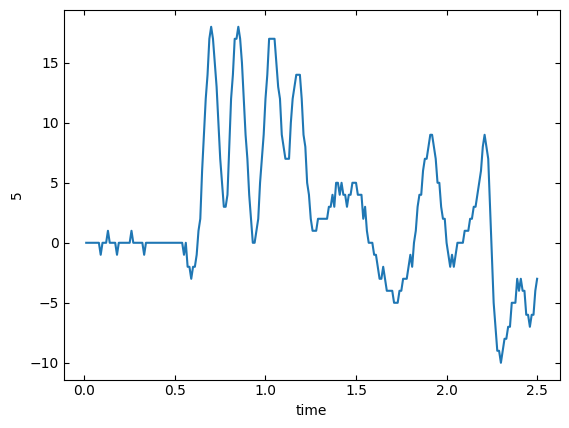

In [21]:
sns.lineplot(selected_data)

Plot wheel speed against time for multiple trials

<Axes: xlabel='time'>

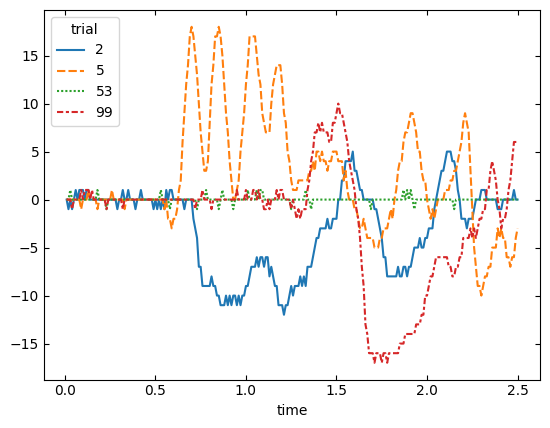

In [22]:
wanted_trials = [5,2,99,53]
selected_data = wheel_df[wanted_trials]

sns.lineplot(selected_data)

Make a plot showing two trials of your choice where one trial is shown as a dotted line

<Axes: xlabel='time', ylabel='9'>

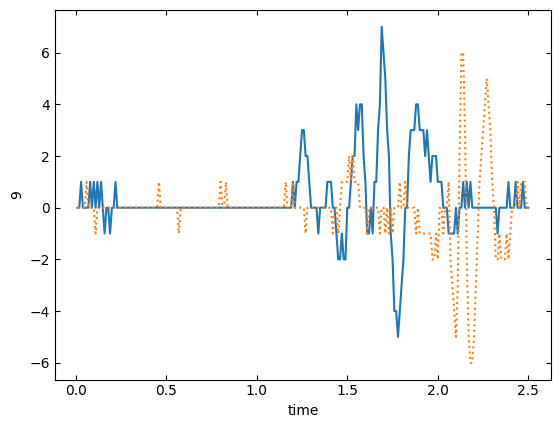

In [23]:
sns.lineplot(wheel_df[9])
sns.lineplot(wheel_df[21], linestyle='dotted')

Recreate the plot above, this time adding a legend to the plot

<Axes: xlabel='time', ylabel='9'>

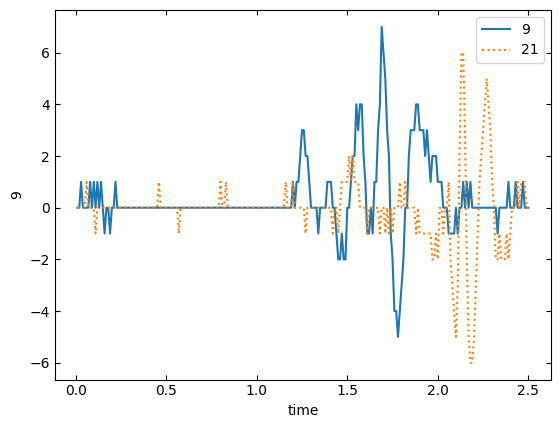

In [24]:
sns.lineplot(wheel_df[9], label=9)
sns.lineplot(wheel_df[21], label=21, linestyle='dotted')

Plot three trials, where each trial has the same line color but a different linestyle

<Axes: xlabel='time', ylabel='9'>

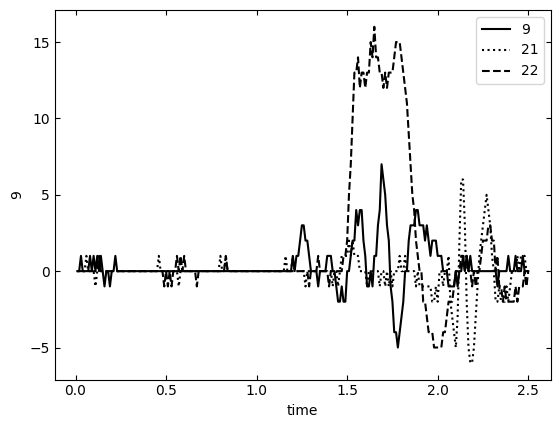

In [25]:
sns.lineplot(wheel_df[9], label=9, color='black', linestyle='solid')
sns.lineplot(wheel_df[21], label=21, color='black', linestyle='dotted')
sns.lineplot(wheel_df[22], label=22, color='black', linestyle='dashed')

Plot three trials, where each trial has a different line color but the same linestyle

<Axes: xlabel='time', ylabel='9'>

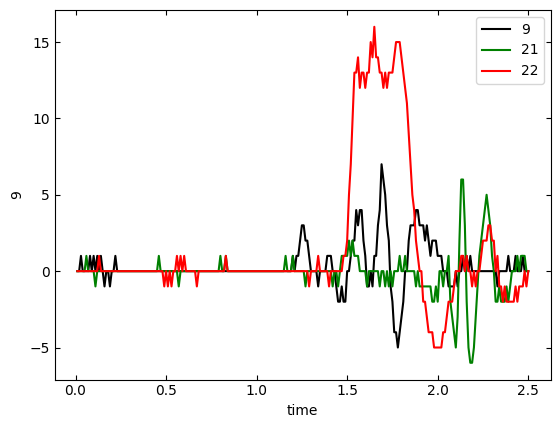

In [26]:
sns.lineplot(wheel_df[9], label=9, color='black', linestyle='solid')
sns.lineplot(wheel_df[21], label=21, color='green', linestyle='solid')
sns.lineplot(wheel_df[22], label=22, color='red', linestyle='solid')

Make a plot that shows the wheel speeds for all trials. Hint - pass the argument `legend=None` to `lineplot` to hide the legend.

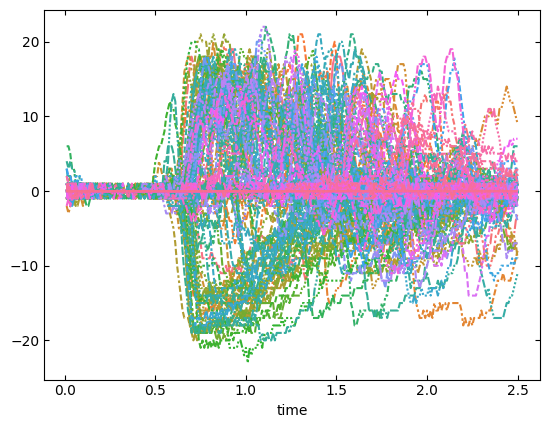

In [28]:
sns.lineplot(wheel_df, legend=None);

Remake the above plot changing the opacity of the lines. Hint - pass the argument `alpha` to `lineplot`. `alpha` takes a value between 0 and 1. 

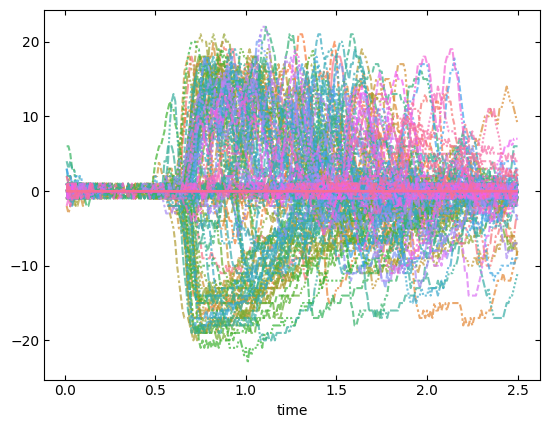

In [29]:
sns.lineplot(wheel_df, legend=None, alpha=0.7);

Experiment with the `alpha` value to find which best displays the lines

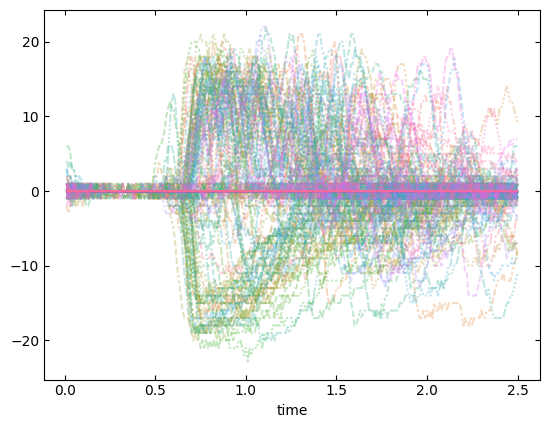

In [30]:
sns.lineplot(wheel_df, legend=None, alpha=0.3);

**BONUS** This looks overplotted! Instead we can make a heatmap, which shows how many datapoints are in a region of the plot.

Pandas and seaborn give us all the tools we need for this. The following cell plots a heatmap

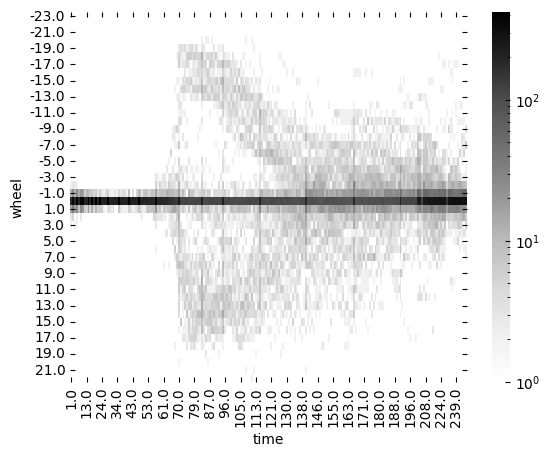

In [31]:
time_bin = wheel_df_reset_index['time'] // .01
sns.heatmap(wheel_df_reset_index.groupby(['wheel', time_bin]).size().unstack(fill_value=0),norm=LogNorm() , cmap=plt.cm.Greys,);


What happens when you change the values of the time bins to be ten times wider?


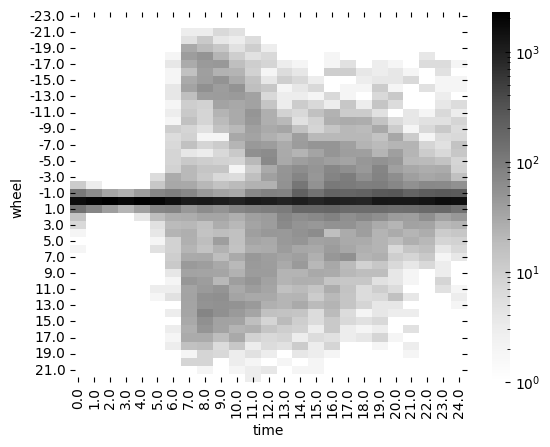

In [32]:
time_bin = wheel_df_reset_index['time'] // .1
sns.heatmap(wheel_df_reset_index.groupby(['wheel', time_bin]).size().unstack(fill_value=0),norm=LogNorm() , cmap=plt.cm.Greys,);


## Describing Data with Metrics: Determining Turning Direction

Data analysis is all about making sense of data. Metric statistics like averages help us to do this. Metrics can help us to minimise the amount of data that we need to think about - which is helpful when working with large datasets. For example if you are interested in the price of food in different supermarkets in your town, it might be overwhelming to look at the individual prices of every item. Instead you could look at the average price of all items.

Metrics are also useful in classifying data. Working with the wheel speed data, a natural question is - which way does the subject turn the wheel? From the wheel speeds, we can answer this question using metrics!

We can then filter our data based on our metrics. For example, we can look at only trials in which the wheel was turned to the left.


**Libraries Used:**

- **Pandas:**
    - `df.mean()`: calculate the mean of a dataframe
    - `df[df < 15]`: filtering based on a condition
    - `len(df)` : count the number of rows in a dataframe



**Example**
This example shows how to calculate the mean of values in a dataframe and use index filtering to get the original data where the mean is less than 1.

```
mean_df = df.mean() # calcuate mean of dataframe
mean_df_less_than_one = mean_df[mean_df < 1] # find rows where the mean is less than 1
data_with_mean_less_than_one = df[mean_df_less_than_one.index] # get original data where mean is less than 1
```


In [33]:
wheel_df = dataset['wheel'].to_dataframe().reset_index().set_index(['time', 'trial'])['wheel'].unstack()

**Exercises**

Calculate the mean wheel speed for each trial from `ẁheel_df`. Name the result `mean_wheel_speeds`

In [34]:
mean_wheel_speeds = wheel_df.mean()
mean_wheel_speeds

trial
1      4.376
2     -2.944
3      2.616
4     -0.268
5      2.532
       ...  
210    1.268
211    2.364
212   -0.004
213   -0.008
214    0.476
Length: 214, dtype: float32

We will use `mean_df` and `wheel_df` to get the wheel speeds where the mean speed was greater than 0.

First, find the trial numbers where the mean wheel speed is greater than 0

In [35]:
selected_trials = mean_wheel_speeds[mean_wheel_speeds > 0]
selected_trials

trial
1      4.376
3      2.616
5      2.532
6      0.940
9      0.336
       ...  
207    0.740
209    0.736
210    1.268
211    2.364
214    0.476
Length: 116, dtype: float32

How many trials have a mean wheel speed greater than 0?

In [36]:
len(selected_trials)

116

Now get the wheel speeds for the trials found above and name the resulting dataframe `selected_data`

In [37]:
selected_data = wheel_df[selected_trials.index]

Plot the wheen speeds of selected_data

<Axes: xlabel='time'>

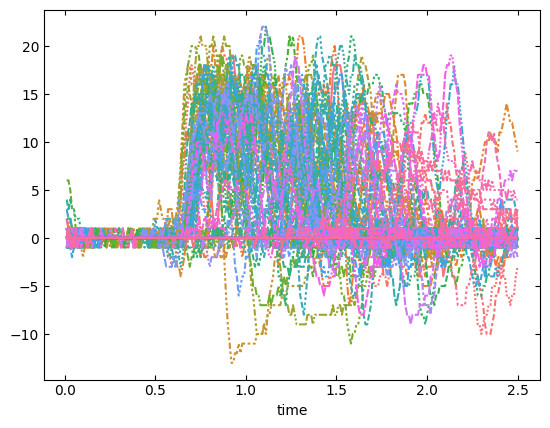

In [38]:
sns.lineplot(selected_data, legend=None)

Find the number of trials where the mean wheel speed is less than 0.

In [39]:
len(mean_wheel_speeds[mean_wheel_speeds < 0].index)

90

Find the number of trials where the mean wheel speed is 0.

In [40]:
len(mean_wheel_speeds[mean_wheel_speeds == 0].index)

8

Let's try another approach. Instead we will find trials whose maximum wheel speed is greater than 10.
Determine the maximum wheel speed for each trial. Call this `max_wheel_speeds`


In [41]:
max_wheel_speeds = wheel_df.max()
max_wheel_speeds

trial
1      19.0
2       5.0
3      14.0
4       7.0
5      18.0
       ... 
210     9.0
211    10.0
212     1.0
213     1.0
214    12.0
Length: 214, dtype: float32

Find the trials whose maximum wheel speed is greater than 10

In [42]:
selected_trials = max_wheel_speeds[max_wheel_speeds>10]
selected_trials

trial
1      19.0
3      14.0
5      18.0
6      14.0
10     20.0
       ... 
191    19.0
198    13.0
201    14.0
207    11.0
214    12.0
Length: 80, dtype: float32

<Axes: xlabel='time'>

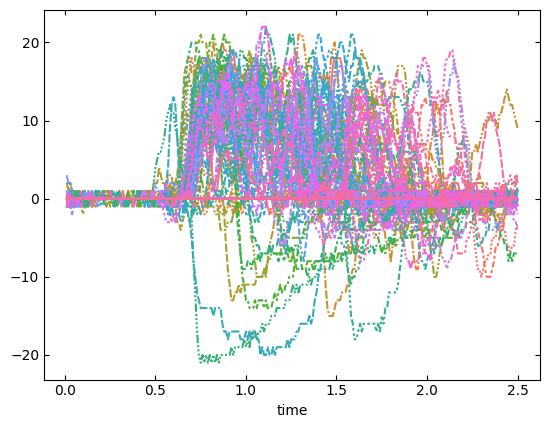

In [43]:
selected_data = wheel_df[selected_trials.index]
sns.lineplot(selected_data, legend=None)

How many trials have a maximum wheel speed greater than 10?

In [44]:
len(selected_trials)

80

How many trials are in the data in total?

In [45]:
len(mean_wheel_speeds)

214

## Letting Python Talk To Us With print Strings : Result Validation

A useful feature of Python is being able to print text to the screen - infact it is a crucial feature of almost every programming language. 
In Python we can directly integrate our calculated results into print statements that are human readable and easily understandable. Instead of printing many seemingly random numbers, we can produce cleanly formatted sentences. 

We will use print statements to compare different metrics to determine the wheel turning direction.

We have two metrics to determine the wheel turning direction:
* when the mean wheel speed is greater than 0, assume the wheel was turned to the right
* when the maximum turning speed is greater than 10, assume the wheel was turned to the right

and the authors of the dataset also have their own method to determine which way the mouse turned the wheel. This information is in the `response_type` data. A `response_type` of 1 corresponds to a right turn, -1 to a left turn and 0 to no turning at all.


Let's compare these different assessments of wheel turning direction with print statements.


**Libraries Used:**

- **Python:**
    - `print(f'this is a formatted string with some {information}')`: print a formatted string to the console containing `information` from a Python variable

- **Pandas:**
    -  `df[df['column1'] == 8]` : filtering a multicolumn dataframe based on a condition
    - `df['column2'].isin(values)`: find rows of dataframe where datapoints are contained in a list of values
    - `df[(df['column2'] == 4) & (df['column1'] > 2)`] : filtering a dataframe based on multiple conditions
    - `len(df)` : count the number of rows in a dataframe

 
  **Example**

A rows of a dataframe are selected based on two conditions - where `col_A` is 9 and where `col_B` is either 1,2 or 4. The number of rows selected is then printed using a print format string.

```
selected_df = df[(df['col_A'] == 9) & df['col_B'].isin([1,2,4]) # get the rows of a data frame where col_A is 9 and col_B is one of 1,2 or 4.
print(f'the length of my filtered dataframe is {len(selected_df)}') # print the length of selected_df with a format string
```
  
 

Get response types from Steinmetz data

In [46]:
response_df = dataset.response_type.to_dataframe()
response_df.reset_index(inplace=True)

**Example exercise** 

```
variable_A = 83
print(f'the value of my variable is {"XXXXXXXX"}' 
```
**Solution:**
```
variable_A = 83
print(f'the value of my variable is {variable_A}' 
```

**Exercises**

Fill in the blank in the print statement below to print the number of trials where the mean speed is less than zero

In [47]:
num_trials_with_mean_less_than_zero = len(mean_wheel_speeds[mean_wheel_speeds<0])
print(f"The number of trials where the mean speed is less than zero is {'XXXXXXXXXXXXX'}")

The number of trials where the mean speed is less than zero is XXXXXXXXXXXXX


In [48]:
num_trials_with_mean_less_than_zero = len(mean_wheel_speeds[mean_wheel_speeds<0])
print(f"The number of trials where the mean speed is less than zero is {num_trials_with_mean_less_than_zero}")

The number of trials where the mean speed is less than zero is 90


Fill in the blank below

In [49]:
num_trials_with_mean_equal_to_zero = len(mean_wheel_speeds[mean_wheel_speeds==0])
print(f"{'XXXXXXXXXX'} trials had a mean speed of zero")

XXXXXXXXXX trials had a mean speed of zero


In [50]:
num_trials_with_mean_equal_to_zero = len(mean_wheel_speeds[mean_wheel_speeds==0])
print(f"{num_trials_with_mean_equal_to_zero} trials had a mean speed of zero")

8 trials had a mean speed of zero


Fill in the two blanks below with variables to print the number of trials with 0 mean speed and the total number of trials

In [51]:
print(f"{'XXXXXXXXXXXXX'} out of {'XXXXXXXX'} trials had a mean speed of zero")

XXXXXXXXXXXXX out of XXXXXXXX trials had a mean speed of zero


In [52]:
print(f"{num_trials_with_mean_equal_to_zero} out of {len(mean_wheel_speeds)} trials had a mean speed of zero")

8 out of 214 trials had a mean speed of zero


print statements can also contain Python operations. Rewrite the above cell to display the percentage of trials with zero mean speed

In [53]:
print(f"{100*num_trials_with_mean_equal_to_zero/len(mean_wheel_speeds)} % of trials had a mean speed of zero")

3.7383177570093458 % of trials had a mean speed of zero


Looks good! But do we really need all those decimal places? We can apply rounding to 4 decimal places by writing the print statement like so

`print(f"{my_variable:.4f}"`

Now display the percentage of trials with zero mean speed rounded to 3 decimal places

In [54]:
print(f"{100*num_trials_with_mean_equal_to_zero/len(mean_wheel_speeds):.3f} % of trials had a mean speed of zero")

3.738 % of trials had a mean speed of zero


Now we will compare the turning direction of our predictions with those of the dataset authors, Steinmetz et. al.

Find trials in `response_df` where `response_type` is 1 (that means wheel was turned to the right). Call this `steinmetz_trials`

In [55]:
steinmetz_trials = response_df[response_df.response_type==1]['trial']
steinmetz_trials

0        1
2        3
4        5
5        6
9       10
      ... 
206    207
208    209
209    210
210    211
213    214
Name: trial, Length: 71, dtype: int64

Get the rows of `mean_wheel_speeds` where `mean_wheel_speeds.index` is in `steinmetz_trials`. These are the mean wheel speeds of trials where the dataset authors recorded a right turn of the wheel

In [56]:
mean_wheel_speeds[mean_wheel_speeds.index.isin(steinmetz_trials)]

trial
1      4.376
3      2.616
5      2.532
6      0.940
10     4.276
       ...  
207    0.740
209    0.736
210    1.268
211    2.364
214    0.476
Length: 71, dtype: float32

Find trials where mean speed was positive and response recorded by Steinmetz was 1


In [57]:
trials_with_positive_mean_speed_and_response_1 = mean_wheel_speeds[(mean_wheel_speeds > 0) & (mean_wheel_speeds.index.isin(steinmetz_trials))]

Assess quantitatively the agreement between the recorded responses in the dataset and the response obtained from the mean speed. Fill in the blanks "XXXXXXXXXXX" with appropriate python code. 

In [58]:
print(f'number of trials with response_type==1: {"XXXXXXXXXXXXXXXXXX"}')
print(f'number of trials with positive mean speed: {"XXXXXXXXXXXXXXXXXX"}')
print(f'number of trials with positive mean speed and response_type==1: {"XXXXXXXXXXXXXXXXXX"}')

number of trials with response_type==1: XXXXXXXXXXXXXXXXXX
number of trials with positive mean speed: XXXXXXXXXXXXXXXXXX
number of trials with positive mean speed and response_type==1: XXXXXXXXXXXXXXXXXX


In [59]:
print(f'number of trials with response_type==1: { len(steinmetz_trials)}')
print(f'number of trials with positive mean speed: {len(mean_wheel_speeds[(mean_wheel_speeds > 0) ])}' )
print(f'number of trials with positive mean speed and response_type==1: { len(trials_with_positive_mean_speed_and_response_1)}')

number of trials with response_type==1: 71
number of trials with positive mean speed: 116
number of trials with positive mean speed and response_type==1: 67


Let's repeat the above analysis, but instead taking the criteria for right turning as being trials where the maximum wheel speed is greater than 10.

In [60]:
max_wheel_speeds = wheel_df.max()
max_wheel_speeds[max_wheel_speeds>10].index
trials_with_speed_greater_than_ten_and_response_1 = max_wheel_speeds[(max_wheel_speeds > 10)  & (max_wheel_speeds.index.isin(steinmetz_trials))]


Print the results as before

In [61]:
print(f'number of trials with response_type==1: { len(steinmetz_trials)}')
print(f'number of trials with positive mean speed: {len(mean_wheel_speeds[(mean_wheel_speeds > 0) ])}' )
print(f'number of trials with positive mean speed and response_type==1: { len(trials_with_positive_mean_speed_and_response_1)}')

number of trials with response_type==1: 71
number of trials with positive mean speed: 116
number of trials with positive mean speed and response_type==1: 67
